## Telecom Customer Churn prediction model



problem statement

goal

null and alternative hypothesis

analytical questions

project timelines


Overview
Customer churn is a major problem and one of the most important concerns for large companies. 
Due to the direct effect on the revenues of the companies, especially in the telecom field, companies are seeking to develop means to predict potential customer to churn.
Therefore, finding factors that increase customer churn is important to take necessary actions to reduce this churn. The main contribution of our work is to develop a churn prediction model which assists telecom operators to predict customers who are most likely subject to churn. The model developed in this work uses machine learning techniques on big data platform and builds a new way of features’ engineering and selection.Customer retention and customer satisfaction are essential for a business to succeed. Customer satisfaction is improved by repeating businesses, brand loyalty, and positive word of mouth.Consumers prefer to stay with their current providers due to quality and price. Therefore, new anti-churn strategies must be constantly developed. Data processing automates analytical model building. Machine learning algorithms improve the dataset iteratively to find hidden patterns. Several studies show that machine learning can predict churn and severe problems in competitive service sectors. Predicting churning customers early on can be a valuable revenue source. 



Null hypothesis :
    1.there's a significant difference in the average monthly charges between churners and non-churners

    1. There is a dominant attribute that affects churn
    2. The customer is not likely to churn
 
    Alternative hypothesis:
    1.there is no significant difference in the average monthly charges between churners and non-churners
    1. There is no dominant attribute that affects churn
    2. The customer is  likely to churn
 
   ### Analytical questions
 
    1.What is the total churn rate?
    2.How does the different boolean attributes affect the churn?
    3.How does the different non-boolean attributes affect the churn?
    4.How does the different numerical attributes affect the churn?
    5. How does tenure affect the churn?
    6.How does the type of internet service affect churn?
    7.How does the type of contract affect the churn?
    8.How does the type of payment method affect the churn?



In [241]:
import pyodbc
from dotenv import dotenv_values  #import the dotenv_values function from the dotenv package
import pandas as pd
import warnings
import io
import requests
 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
from scipy import stats
warnings.filterwarnings('ignore')

In [242]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')


# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")



In [243]:
#creating a connection sring to the SQL  database
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"

In [244]:
connection = pyodbc.connect(connection_string)

In [245]:
query = "Select * from dbo.LP2_Telco_churn_first_3000"

data1 = pd.read_sql(query, connection)

In [246]:
# the first five rows of the first dataset
data1.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [247]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [248]:
data1.isna().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

In [249]:
data1.shape

(3000, 21)

In [250]:
data1.duplicated().sum()

0

Observations of the first data:
-the data has missing values
-the dataset has 3000 rows and 21columns
-there are no duplicates

In [251]:
url = 'https://raw.github.com/Azubi-Africa/Career_Accelerator_LP2-Classifcation/main/LP2_Telco-churn-second-2000.csv'
download = requests.get(url).content
data2 = pd.read_csv(io.StringIO(download.decode('utf-8')))
data2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [252]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2043 non-null   object 
 1   gender            2043 non-null   object 
 2   SeniorCitizen     2043 non-null   int64  
 3   Partner           2043 non-null   object 
 4   Dependents        2043 non-null   object 
 5   tenure            2043 non-null   int64  
 6   PhoneService      2043 non-null   object 
 7   MultipleLines     2043 non-null   object 
 8   InternetService   2043 non-null   object 
 9   OnlineSecurity    2043 non-null   object 
 10  OnlineBackup      2043 non-null   object 
 11  DeviceProtection  2043 non-null   object 
 12  TechSupport       2043 non-null   object 
 13  StreamingTV       2043 non-null   object 
 14  StreamingMovies   2043 non-null   object 
 15  Contract          2043 non-null   object 
 16  PaperlessBilling  2043 non-null   object 


In [253]:
data2.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

# Observations for data2:
-there is no missing values
-the totalcharge column is an object instead of a float
-the dataset has 2043 rows and 21 columns


## Cleaning the training datasets
-Firstly replaced the NaN values in data2 then change the data type from object to float
-then concantinate the dataset

In [254]:
def replace_nan_and_convert_to_float(df, column_name):
    """
    Replaces NaN values with zero and converts the column type to float for a specified column.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the column to process.
    - column_name (str): The name of the column to process.
    
    Returns:
    - pd.DataFrame: DataFrame with NaN values replaced and specified column converted to float.
    """
    # Convert column to numeric, setting errors='coerce' to convert non-numeric values to NaN
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    # Replace NaN values with 0
    df['TotalCharges'] = df['TotalCharges'].fillna(0)
    return df

# Assuming you have a DataFrame `df` already defined
# Sample DataFrame creation for demonstration
#data = {'CustomerID': [1, 2, 3, 4], 'TotalCharges': ['100', '200.5', 'NaN', 'not a number']}
df = pd.DataFrame(data2)

# Process the 'TotalCharges' column: replace NaN with zero and convert to float
df = replace_nan_and_convert_to_float(df, 'TotalCharges')

print("\nDataFrame after processing:")
print(df.head())
data2=df



DataFrame after processing:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  5600-PDUJF    Male              0      No         No       6          Yes   
1  8292-TYSPY    Male              0      No         No      19          Yes   
2  0567-XRHCU  Female              0     Yes        Yes      69           No   
3  1867-BDVFH    Male              0     Yes        Yes      11          Yes   
4  2067-QYTCF  Female              0     Yes         No      64          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0                No             DSL             No  ...               No   
1                No             DSL             No  ...              Yes   
2  No phone service             DSL            Yes  ...              Yes   
3               Yes     Fiber optic             No  ...               No   
4               Yes     Fiber optic             No  ...              Yes   

  TechSupport StreamingTV Streami

In [255]:
training_data = pd.concat([data1, data2], axis=0,ignore_index=True)
training_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,0,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,0,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,0,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [256]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   int64  
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 


## EDA

In [257]:
#Summary statistics of numerical columns
training_data.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,5043.0,0.162403,0.368857,0.0,0.000,0.000000,0.000000,1.000000
tenure,5043.0,32.576641,24.529807,0.0,9.000,29.000000,56.000000,72.000000
MonthlyCharges,5043.0,65.090214,30.068133,18.4,35.775,70.550003,90.050003,118.650002
TotalCharges,5038.0,2300.692041,2269.502705,0.0,417.125,1400.699988,3860.599976,8670.100000


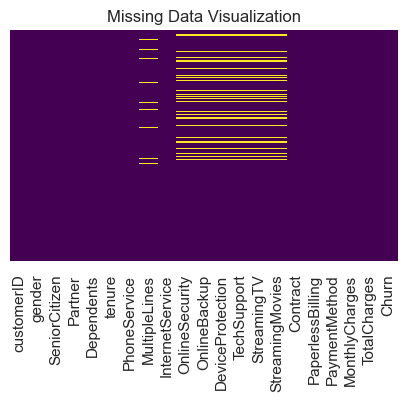

Missing Values Summary:
 customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64


In [258]:
# Check for missing values
missing_values=training_data.isnull().sum()
#missing_values
# Visualize missing data
plt.figure(figsize=(5, 3))
sns.heatmap(training_data.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title('Missing Data Visualization')
plt.show()

# Display missing values summary
print("Missing Values Summary:\n", missing_values)

In [259]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   int64  
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 


In [260]:
training_data.duplicated().sum()

0

In [261]:
def convert_to_yes_no(df, columns):
    """
    Converts multiple columns with mixed values (True, False, Yes, No) to only Yes and No.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the columns to be converted.
    - columns (list of str): List of column names to convert.
    
    Returns:
    - pd.DataFrame: DataFrame with the specified columns converted to Yes and No.
    """
    # Define a mapping from original to desired values
    conversion_map = {
        True: 'Yes',
        'True': 'Yes',
        False: 'No',
        'False': 'No',
        'Yes': 'Yes',
        'No': 'No',
        'yes': 'Yes',  # Handling lowercase input
        'no': 'No',    # Handling lowercase input
        'YES': 'Yes',  # Handling uppercase input
        'NO': 'No'     # Handling uppercase input
    }
    
    # Apply the mapping to each specified column
    for column in columns:
        if column in df.columns:
            df[column] = df[column].map(conversion_map)
    
    return df

# Assuming 'training_data' is your DataFrame and already defined
# Example column names to be converted
columns_to_convert = ['Churn','Partner', 'Dependents', 'PhoneService']

# Convert specified columns to only contain Yes and No
df = convert_to_yes_no(training_data, columns_to_convert)

print(df)
train_data=df
train_data.head()

      customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0     7590-VHVEG  Female              0     Yes         No       1   
1     5575-GNVDE    Male              0      No         No      34   
2     3668-QPYBK    Male              0      No         No       2   
3     7795-CFOCW    Male              0      No         No      45   
4     9237-HQITU  Female              0      No         No       2   
...          ...     ...            ...     ...        ...     ...   
5038  6840-RESVB    Male              0     Yes        Yes      24   
5039  2234-XADUH  Female              0     Yes        Yes      72   
5040  4801-JZAZL  Female              0     Yes        Yes      11   
5041  8361-LTMKD    Male              1     Yes         No       4   
5042  3186-AJIEK    Male              0      No         No      66   

     PhoneService     MultipleLines InternetService OnlineSecurity  ...  \
0              No              None             DSL          False  ...   
1        

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,No
1,5575-GNVDE,Male,0,No,No,34,Yes,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,No
2,3668-QPYBK,Male,0,No,No,2,Yes,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,Yes
3,7795-CFOCW,Male,0,No,No,45,No,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,No
4,9237-HQITU,Female,0,No,No,2,Yes,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,Yes


In [265]:
train_data.to_csv('Trainz_data.csv')

array([[<Axes: title={'center': 'SeniorCitizen'}>,
        <Axes: title={'center': 'tenure'}>],
       [<Axes: title={'center': 'MonthlyCharges'}>,
        <Axes: title={'center': 'TotalCharges'}>]], dtype=object)

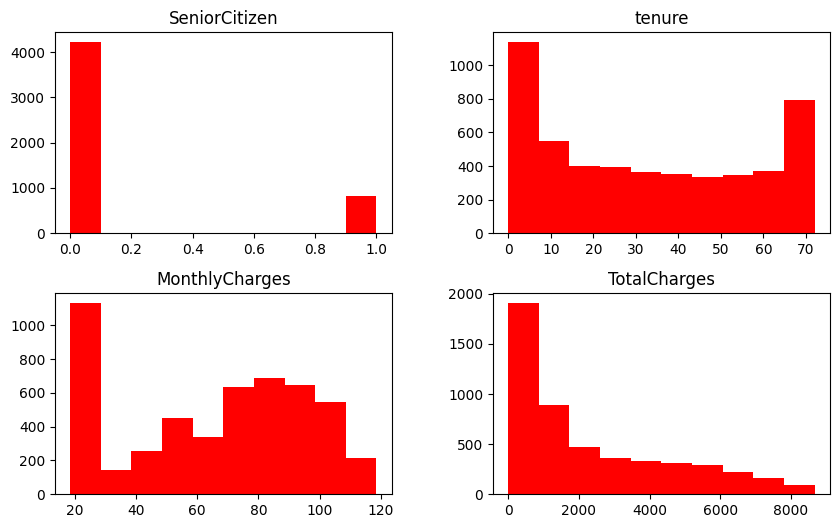

In [ ]:
train_data.hist(figsize=(10,6),grid=False, color='red')

<Axes: ylabel='Density'>

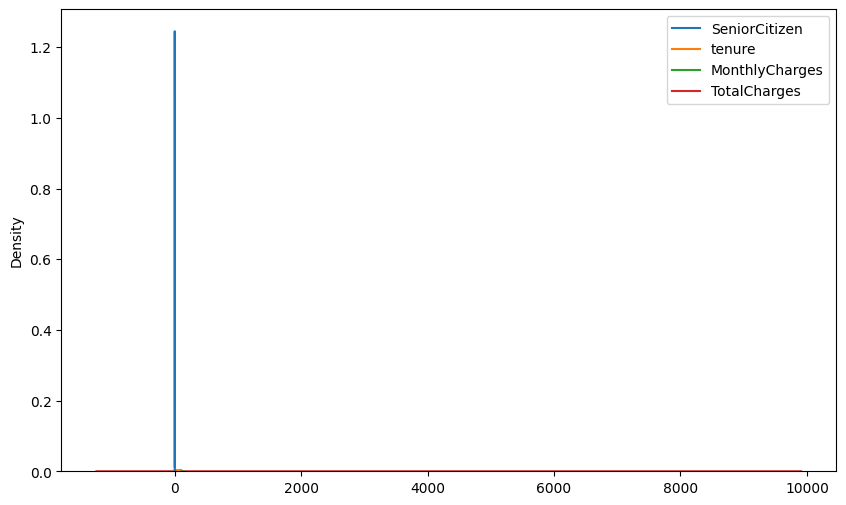

In [ ]:
#density distribution
plt.figure(figsize=(10,6))
sns.kdeplot(train_data)

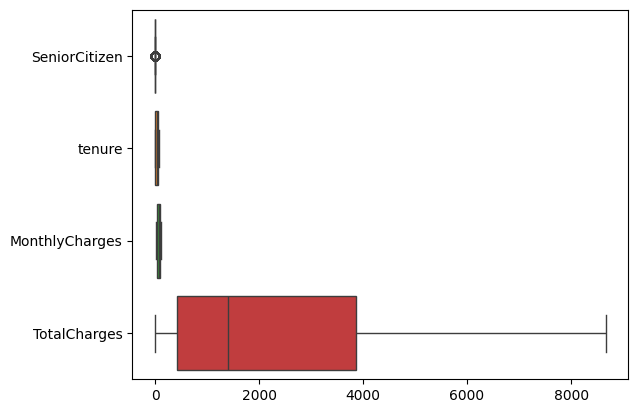

In [ ]:
#checking outliers
sns.boxplot(train_data, orient='h')
plt.show()


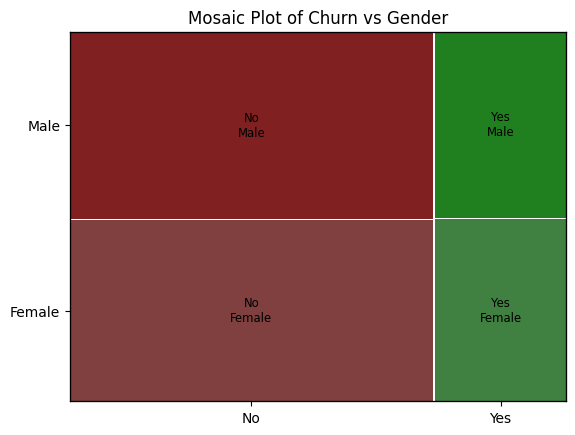

In [ ]:
mosaic(train_data, ['Churn', 'gender'], title='Mosaic Plot of Churn vs Gender')
plt.show()

If the tiles for churn and non-churn are of similar size within each gender category, it suggests that churn rates are similar across genders.
If there's a noticeable difference in tile sizes between genders, it suggests that churn rates differ significantly between male and female customers.
If the tile for churn is much larger than the tile for non-churn within a gender category, it indicates a higher churn rate for that gender.
Conversely, if the tile for non-churn is much larger, it indicates a lower churn rate for that gender.

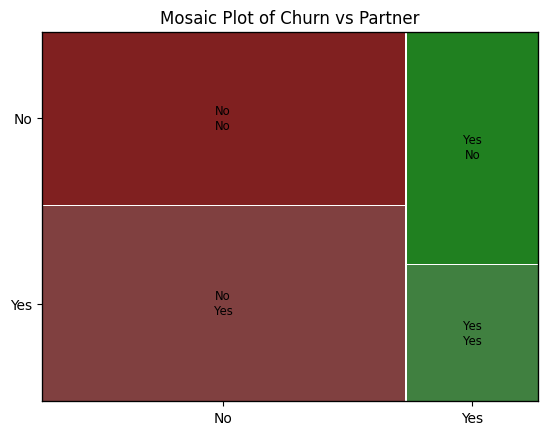

In [ ]:
mosaic(train_data, ['Churn', 'Partner'], title='Mosaic Plot of Churn vs Partner')
plt.show()

In [ ]:
#skewness
categorical_columns=train_data.select_dtypes('object').columns
train_data.drop(categorical_columns,axis=1).skew()

SeniorCitizen     1.831228
tenure            0.225132
MonthlyCharges   -0.238767
TotalCharges      0.944701
dtype: float64

In [ ]:
#the skewness of numeric data in the dataset is
train_data.drop(categorical_columns,axis=1).skew().sum()

2.76229476043804

In [ ]:
categorical_columns

Index(['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object')

In [ ]:
numerical_columns=train_data.select_dtypes('number').columns
numerical_columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

In [ ]:
correlation=train_data[numerical_columns].corr()
correlation

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
SeniorCitizen,1.000000,0.004597,0.221780,0.095444
tenure,0.004597,1.000000,0.240645,0.826379
MonthlyCharges,0.221780,0.240645,1.000000,0.646927
TotalCharges,0.095444,0.826379,0.646927,1.000000


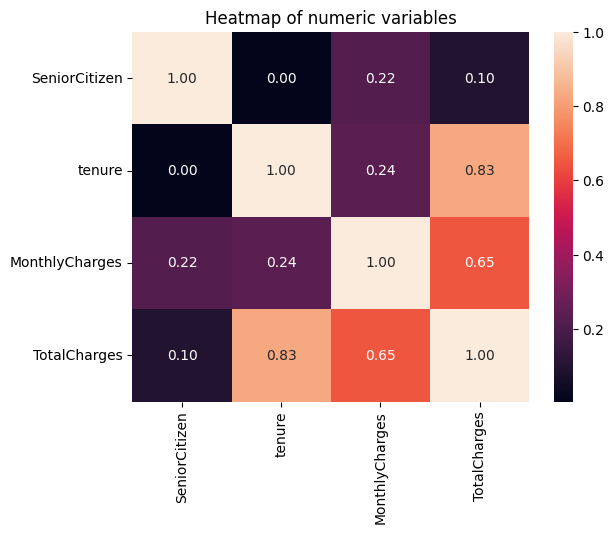

In [ ]:
sns.heatmap(correlation,annot=True,fmt='.2f')
plt.title('Heatmap of numeric variables',fontsize=12)
plt.show()

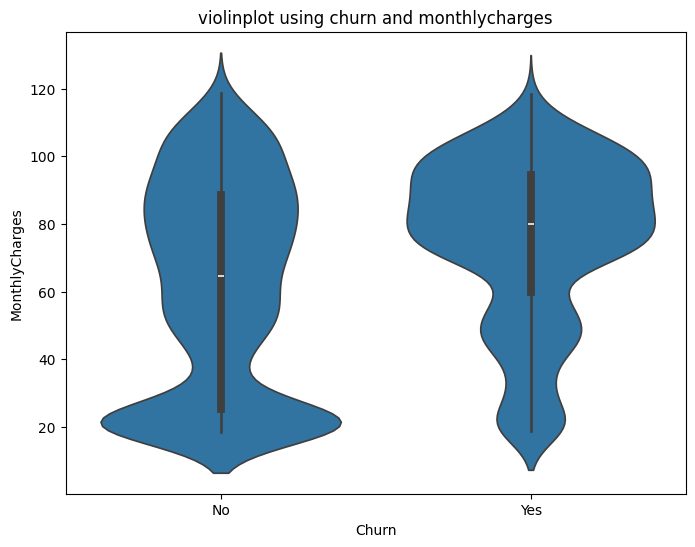

In [ ]:
plt.figure(figsize=(8,6))
sns.violinplot(data=train_data,x='Churn',y='MonthlyCharges')
plt.title('violinplot using churn and monthlycharges',fontsize=12)
plt.show()

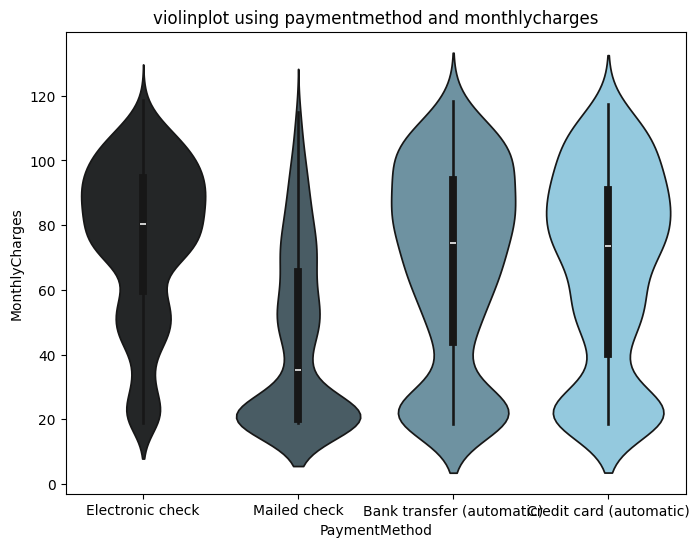

In [ ]:
plt.figure(figsize=(8,6))
sns.violinplot(data=train_data,x='PaymentMethod',y='MonthlyCharges',hue='PaymentMethod',palette='dark:skyblue')
plt.title('violinplot using paymentmethod and monthlycharges',fontsize=12)
plt.show()

most people who left their monthly charges was above 80

# Hypothesis testing

In [ ]:
# Filter the dataset for churners and non-churners
churners = train_data[train_data['Churn'] == 'Yes']
non_churners = train_data[train_data['Churn'] =='No']

# Extract monthly charges for churners and non-churners
churner_monthly_charges = churners['MonthlyCharges']
non_churner_monthly_charges = non_churners['MonthlyCharges']

# Perform t-test for independent samples
t_statistic, p_value = stats.ttest_ind(churner_monthly_charges, non_churner_monthly_charges)

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Determine significance level
alpha = 0.05
if p_value < alpha:
    print("Reject null hypothesis: There is a significant difference in average monthly charges between churners and non-churners.")
else:
    print("Fail to reject null hypothesis: There is no significant difference in average monthly charges between churners and non-churners.")

T-statistic: 14.666372695847157
P-value: 1.0069968155605386e-47
Reject null hypothesis: There is a significant difference in average monthly charges between churners and non-churners.


## Answer analytical questions

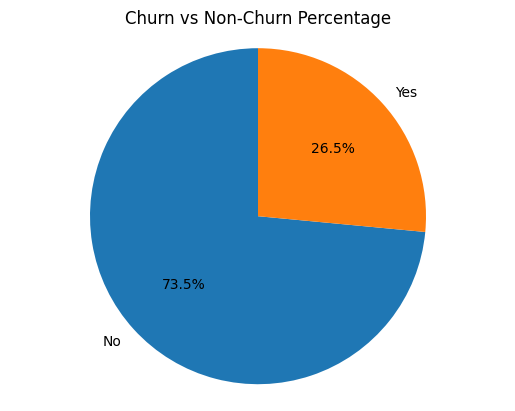

In [ ]:
## 1. What is the total churn rate

def calculate_churn_percentage(df, column_name):
    """
    Calculate the percentage of churn and non-churn in a specified column.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame to analyze.
    - column_name (str): The column name where churn data is stored.
    
    Returns:
    - dict: Dictionary containing the percentage of churn and non-churn.
    """
    # Calculate the frequency of each category in the specified column
    counts = df['Churn'].value_counts(normalize=True)
    
    # Convert the frequencies to percentage
    percentages = counts * 100
    
    return percentages

def plot_churn_pie_chart(percentages):
    """
    Plots a pie chart of churn and non-churn percentages.
    
    Parameters:
    - percentages (pd.Series): Series containing the percentages of churn and non-churn.
    """
    # Create a pie chart
    fig, ax = plt.subplots()
    ax.pie(percentages, labels=percentages.index, autopct='%1.1f%%', startangle=90)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    # Title
    plt.title('Churn vs Non-Churn Percentage')

    # Show the plot
    plt.show()

# Example usage with a sample DataFrame
#data = {'CustomerID': [1, 2, 3, 4, 5, 6, 7, 8], 'Churn': ['Yes', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'No']}
df = pd.DataFrame(train_data)

# Calculate churn and non-churn percentages
churn_percentages = calculate_churn_percentage(df, 'Churn')

# Plot the pie chart
plot_churn_pie_chart(churn_percentages)

## 2. How does the different boolean attribute affect the churn

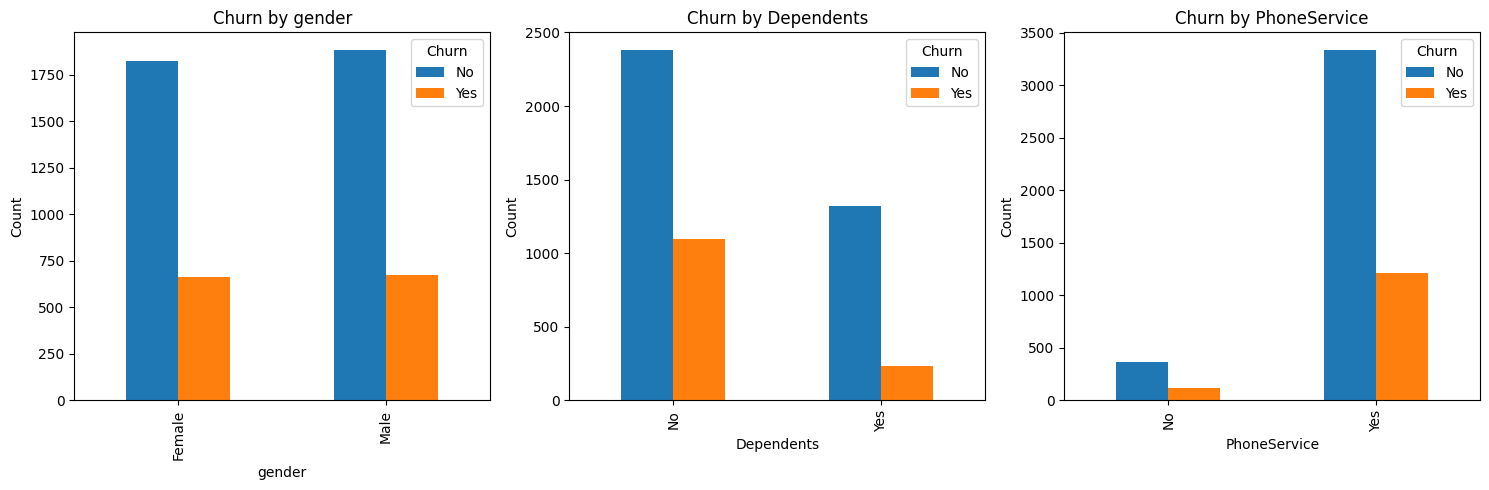

In [ ]:
# How does gender, partner and phone service affect churn
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for ax, feature in zip(axes, ['gender', 'Dependents', 'PhoneService']):
    df.groupby([feature, 'Churn']).size().unstack().plot(kind='bar', ax=ax, title=f'Churn by {feature}')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

## 3. How does the different non-boolean affect churn e.g Contract,PaymentMethod,

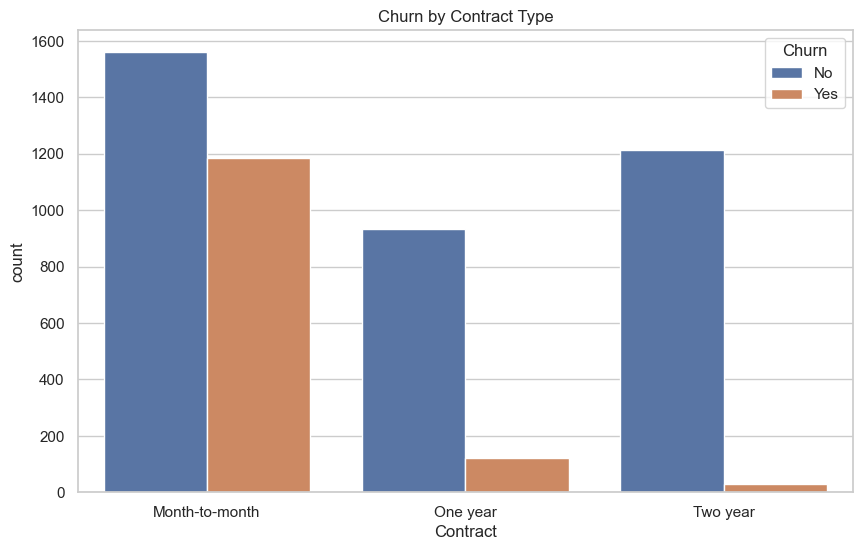

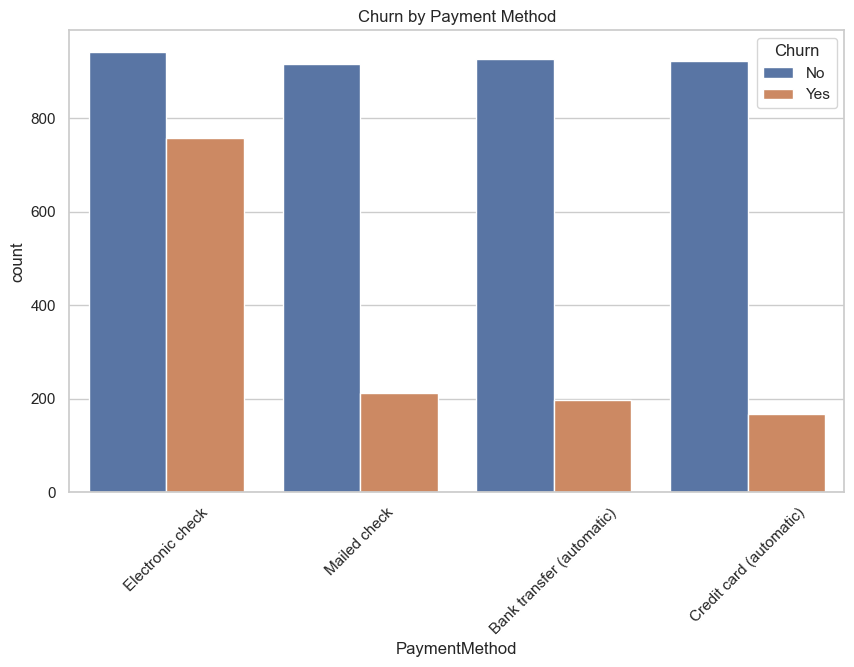

In [267]:
# Setting up the visualization environment
sns.set(style="whitegrid")

# Bar plot for Contract vs Churn
plt.figure(figsize=(10, 6))
sns.countplot(x='Contract', hue='Churn', data=train_data)
plt.title('Churn by Contract Type')
plt.show()

# Clustered bar plot for Payment Method vs Churn
plt.figure(figsize=(10, 6))
sns.countplot(x='PaymentMethod', hue='Churn', data=train_data)
plt.title('Churn by Payment Method')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()

## 4 How does monthly charges and total charges affect churn

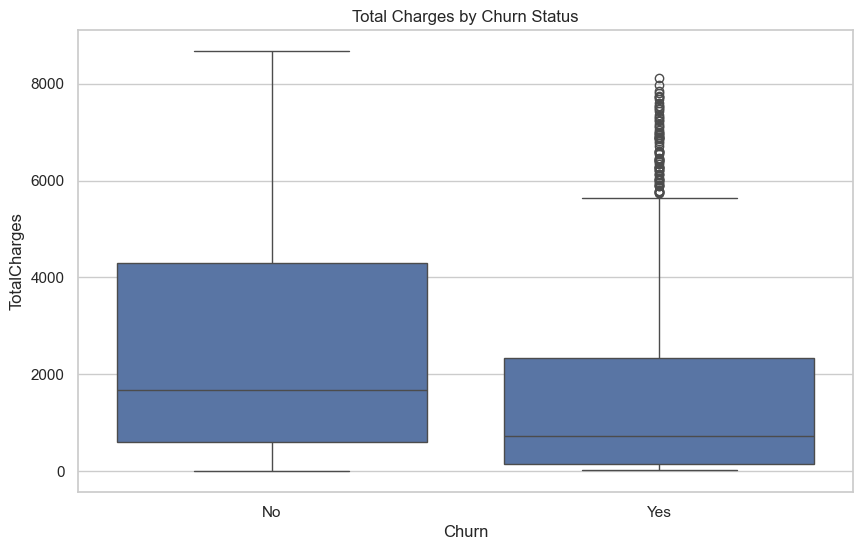

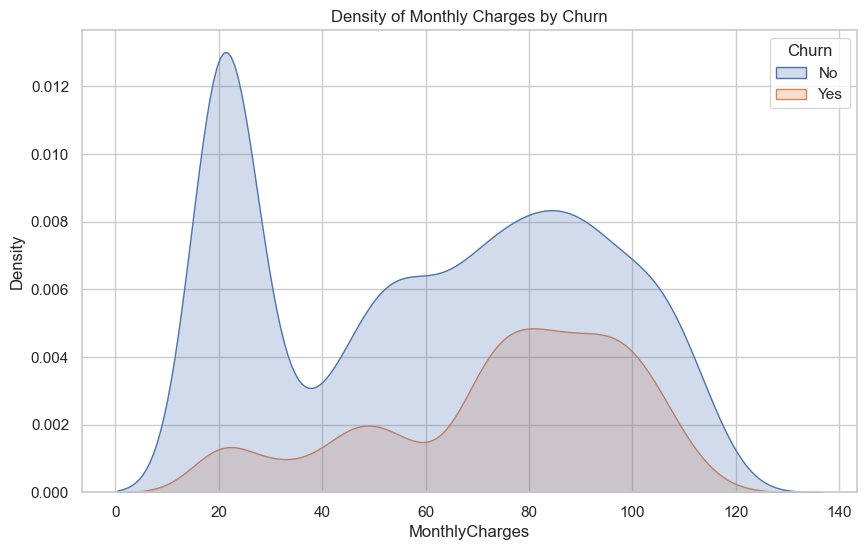

In [268]:
# Setting up the visualization environment
sns.set(style="whitegrid")


# Box Plot for Total Charges by Churn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='TotalCharges', data=train_data)
plt.title('Total Charges by Churn Status')
plt.show()

# Density Plot for Monthly Charges by Churn
plt.figure(figsize=(10, 6))
sns.kdeplot(data=train_data, x='MonthlyCharges', hue='Churn', fill=True)
plt.title('Density of Monthly Charges by Churn')
plt.show()

## 5. How does the type of internet service affect the churn

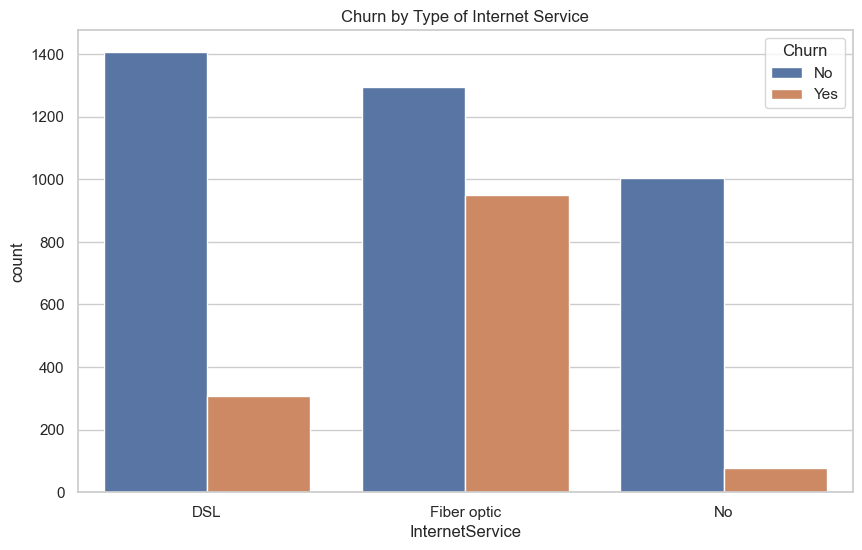

In [269]:
# Count Plot for Internet Service vs Churn
plt.figure(figsize=(10, 6))
sns.countplot(x='InternetService', hue='Churn', data=train_data)
plt.title('Churn by Type of Internet Service')
plt.show()